<a href="https://colab.research.google.com/github/Santiago-Quinteros/MLP-MNIST-Multi-Layer-Perceptron-TP/blob/main/MLP_MNIST_Multi_Layer_Perceptron_TP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab session 3 | Multi-Layer Perceptron (MLP) with pytorch

---



## Objective of this lab session: use a multiple layer perceptron to process the MNIST dataset.


**MNIST** is a computer vision dataset. It consists of images of handwritten digits. It also includes labels for each image, telling us which digit it is. In this lab session, we're going to train **Multi-Layer Perceptron** (MLP) models to look at images and predict to which digit they belong.

### 1- Download MNIST dataset

First, start with these lines of code which will automatically download the MNIST dataset.

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.ToTensor() # convert data to torch.FloatTensor

train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

num_train, num_test = len(train_data), len(test_data)
print('number of training data:', num_train, '\n'+'number of test data:', num_test)

100%|██████████| 9912422/9912422 [00:00<00:00, 114089226.11it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 105152512.00it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43830274.78it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 18247632.92it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



number of training data: 60000 
number of test data: 10000


The MNIST dataset is split into two parts: 60,000 samples for training, 10,000 samples for test. Both training set test sets contain images and their corresponding labels.

The following cell creates a **data loader** (DataLoader, [documentation](https://pytorch.org/docs/stable/data.html)) for the test set.

In [ ]:
import torch

batch_size = 20 # how many samples per batch to load
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)

### 2- Data visualization

The first thing to do in a classification task is to take a **look at the data**, make sure that it has been correctly loaded in, then make any initial observations about patterns in that data. The next cell allows to visualize images from the test set with corresponding ground truth labels.

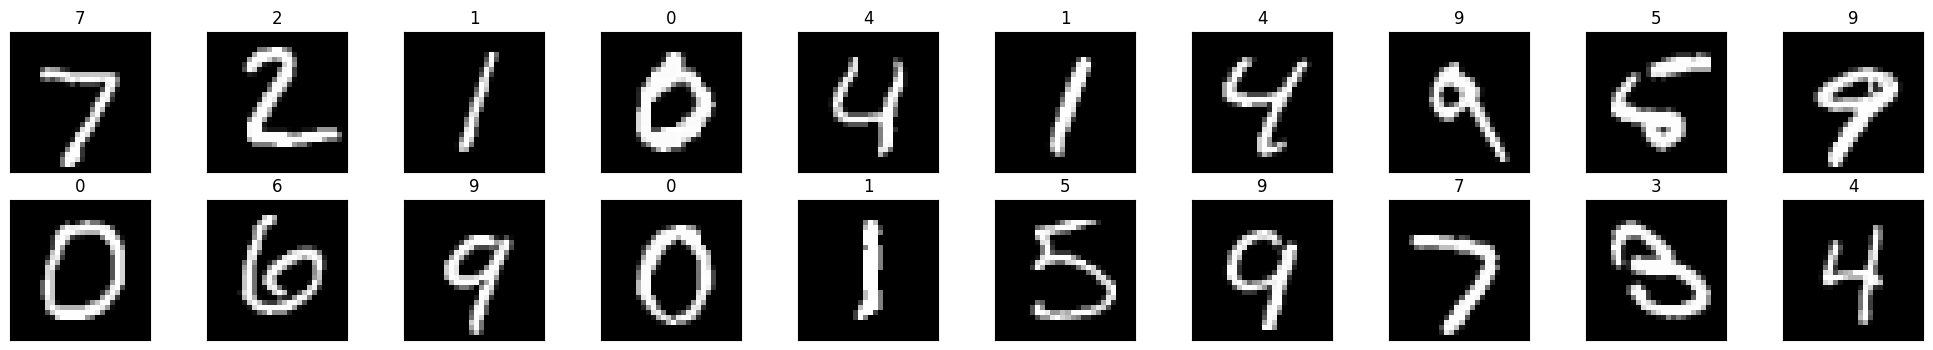

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

data_iter = iter(test_loader)
images, labels = next(data_iter) # obtain one batch from the test set
images = images.numpy()
# plot images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray') # .npsqueeze removes single-dimensional entries from the shape of an array
    ax.set_title(str(labels[idx].item())) # .item() gets the value contained in a Tensor

Every image in MNIST is of a handwritten digit between zero and nine. Let us view one of these images with more details:

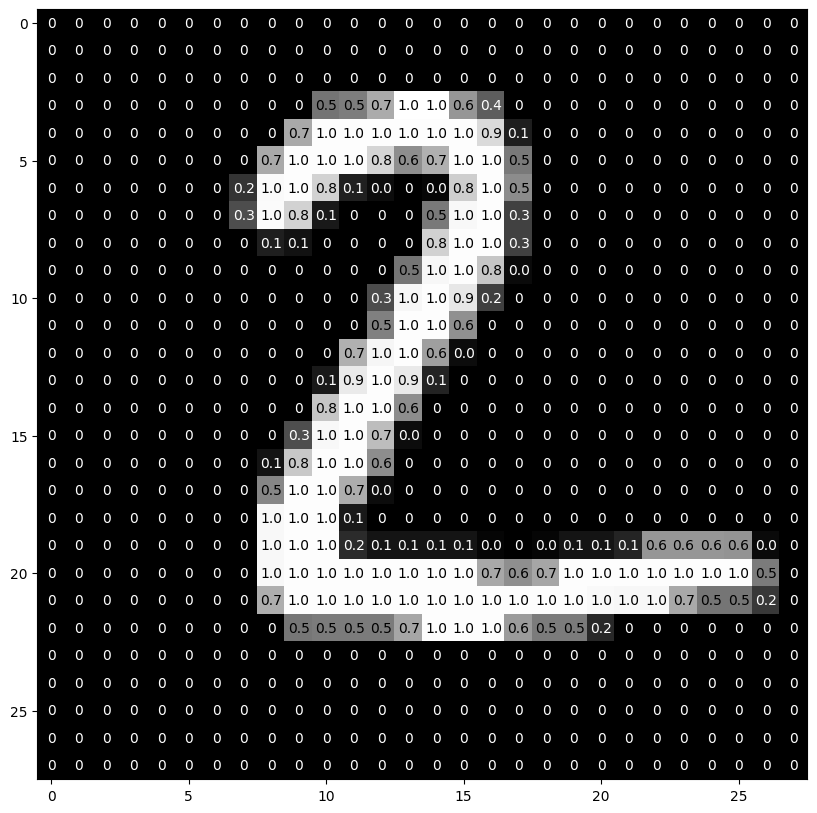

In [ ]:
img = np.squeeze(images[1])
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],1) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x), horizontalalignment='center', verticalalignment='center', color='white' if img[x][y]<thresh else 'black')

Each image is 28 pixels by 28 pixels. Image intensities are normalized between 0 and 1.

### 3- Is my network generalizing well?

It's essential in machine (or deep) learning to consider validation/test sets which will not be used for training such that we can be sure that what we have learned through the network actually generalizes!

In practice, we will extract from the training set a subset (20% of training set) for **validation** purposes.

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

valid_size = 0.2 # percentage of training set to use as validation

# obtain training indices that will be used for validation
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_index, valid_index = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = valid_sampler)

### 4- Simple MLP architecture

Let us define a simple **network architecture**. The network will take as inputs 784-dimensional tensors of pixel values from each image (28x28=784). It will produce as output a tensor of length 10 (i.e. the number of classes) that indicates the class scores for each input image.

In this first network architecture (*Net1*), we will employ a single hidden layer with 10 neurons.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net1(nn.Module):

    def __init__(self):
        super(Net1,self).__init__()
        self.fc1 = nn.Linear(28*28, 10) # linear layer (784 -> 10)

    def forward(self,x):
        x = x.view(-1,28*28) # flatten input image
        x = self.fc1(x)
        return x

        #w=784x10+10x10

For a given image, we aim at computing the probabilities for each digit through a softmax regression model $ y = softmax(Wx+b)$ where *softmax* is the normalized exponential function.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))

Using device cuda


Let us **initialize** the neural network.

In [ ]:
model_1 = Net1() # initialize the neural network
model_1.to(device=device)

Net1(
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)

### 5- Loss function and optimizer

Now, We have to specify the **loss function**. We try to minimize that error: the smaller the error margin, the better our model. In this lab session, the cross-entropy is used as loss function:

$$H_{y}(z) = - \sum_i y_i \log(z_i)$$

where $z$ is our predicted probability distribution, and $y$ is the true distribution. If you look at the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html), you can see that PyTorch’s cross entropy function applies a *softmax* funtion to the output layer and then calculates the log loss.

In [ ]:
criterion = nn.CrossEntropyLoss() # specify loss function (categorical cross-entropy)

We also need to specify the **optimization** algorithm that will be used to minimized the loss function. Here, we will use a standard stochastic gradient descent (SGD). Many other optimization strategies can be emloyed ([documentation](https://pytorch.org/docs/stable/optim.html)).

In [ ]:
optimizer = torch.optim.SGD(model_1.parameters(),lr = 0.01) # specify optimizer (stochastic gradient descent) and learning rate

### 6- Network training

Let us train the network defined above. Each step is described in the comments below.

In [ ]:
n_epochs = 30 # number of epochs to train the model

def training(n_epochs, train_loader, valid_loader, model, criterion, optimizer):

  train_losses, valid_losses = [], []
  # initialize tracker for minimum validation loss
  valid_loss_min = np.Inf  # set initial "min" to infinity

  for epoch in range(n_epochs):
      train_loss, valid_loss = 0, 0 # monitor losses

      # train the model
      model.train() # prep model for training
      for data, label in train_loader:
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.long)
          optimizer.zero_grad() # clear the gradients of all optimized variables
          output = model(data) # forward pass: compute predicted outputs by passing inputs to the model
          loss = criterion(output, label) # calculate the loss
          loss.backward() # backward pass: compute gradient of the loss with respect to model parameters
          optimizer.step() # perform a single optimization step (parameter update)
          train_loss += loss.item() * data.size(0) # update running training loss

      # validate the model
      model.eval()
      for data, label in valid_loader:
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.long)
          with torch.no_grad():
              output = model(data)
          loss = criterion(output,label)
          valid_loss += loss.item() * data.size(0)

      # calculate average loss over an epoch
      train_loss /= len(train_loader.sampler)
      valid_loss /= len(valid_loader.sampler)
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)

      print('epoch: {} \ttraining Loss: {:.6f} \tvalidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

      # save model if validation loss has decreased
      if valid_loss <= valid_loss_min:
          print('validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          valid_loss))
          torch.save(model.state_dict(), 'model.pt')
          valid_loss_min = valid_loss

  return train_losses, valid_losses

Labels as considered as **one-hot vectors**. A one-hot vector is a vector which is 0 in most dimensions, and 1 in a single dimension. In this case, the n$^{th}$ digit is represented as a vector which is 1 in the n$^{th}$ dimension. For example, label 3 corresponds to: [0,0,0,1,0,0,0,0,0,0].

In [ ]:
train_losses_1, valid_losses_1 = training(n_epochs, train_loader, valid_loader, model_1, criterion, optimizer)

epoch: 1 	training Loss: 0.706644 	validation Loss: 0.470264
validation loss decreased (inf --> 0.470264).  Saving model ...
epoch: 2 	training Loss: 0.426590 	validation Loss: 0.403132
validation loss decreased (0.470264 --> 0.403132).  Saving model ...
epoch: 3 	training Loss: 0.381318 	validation Loss: 0.375644
validation loss decreased (0.403132 --> 0.375644).  Saving model ...
epoch: 4 	training Loss: 0.358198 	validation Loss: 0.358694
validation loss decreased (0.375644 --> 0.358694).  Saving model ...
epoch: 5 	training Loss: 0.343595 	validation Loss: 0.347252
validation loss decreased (0.358694 --> 0.347252).  Saving model ...
epoch: 6 	training Loss: 0.332956 	validation Loss: 0.339404
validation loss decreased (0.347252 --> 0.339404).  Saving model ...
epoch: 7 	training Loss: 0.325151 	validation Loss: 0.333269
validation loss decreased (0.339404 --> 0.333269).  Saving model ...
epoch: 8 	training Loss: 0.318690 	validation Loss: 0.327889
validation loss decreased (0.33326

### 7- Convergence

To study the **convergence** of the training process, we plot the evolution of the loss function for both training and validation sets with respect to epochs.

Text(0, 0.5, 'loss value')

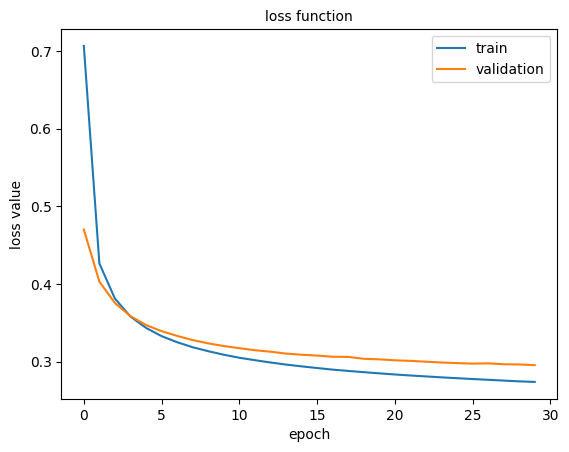

In [ ]:
#Epoch, cada vez que actualizo los pesos

plt.plot(range(n_epochs), train_losses_1)
plt.plot(range(n_epochs), valid_losses_1)
plt.legend(['train', 'validation'], prop={'size': 10})
plt.title('loss function', size=10)
plt.xlabel('epoch', size=10)
plt.ylabel('loss value', size=10)

#Vemos que la que da mejores resultados es la ultima

Let us load the model corresponding to the lowest validation loss.

In [ ]:
model_1.load_state_dict(torch.load('model.pt', map_location=device))

<All keys matched successfully>

### 8- Testing

Finally, we test our best model on previously unseen test data and evaluate it’s performance. Testing on unseen data is a good way to check that our model generalizes well! It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its **overall** loss and **accuracy**.

In [ ]:
def evaluation(model, test_loader, criterion):

  # initialize lists to monitor test loss and accuracy
  test_loss = 0.0
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))

  model.eval() # prep model for evaluation
  for data, label in test_loader:
      data = data.to(device=device, dtype=torch.float32)
      label = label.to(device=device, dtype=torch.long)
      with torch.no_grad():
          output = model(data) # forward pass: compute predicted outputs by passing inputs to the model
      loss = criterion(output, label)
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1) # convert output probabilities to predicted class
      correct = np.squeeze(pred.eq(label.data.view_as(pred))) # compare predictions to true label
      # calculate test accuracy for each object class
      for i in range(len(label)):
          digit = label.data[i]
          class_correct[digit] += correct[i].item()
          class_total[digit] += 1

  # calculate and print avg test loss
  test_loss = test_loss/len(test_loader.sampler)
  print('test Loss: {:.6f}\n'.format(test_loss))
  for i in range(10):
      print('test accuracy of %1s: %2d%% (%2d/%2d)' % (str(i), 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
  print('\ntest accuracy (overall): %2.2f%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))

In [ ]:
evaluation(model_1, test_loader, criterion)

test Loss: 0.277151

test accuracy of 0: 98% (962/980)
test accuracy of 1: 97% (1110/1135)
test accuracy of 2: 89% (922/1032)
test accuracy of 3: 90% (918/1010)
test accuracy of 4: 93% (922/982)
test accuracy of 5: 86% (771/892)
test accuracy of 6: 94% (908/958)
test accuracy of 7: 92% (949/1028)
test accuracy of 8: 88% (866/974)
test accuracy of 9: 88% (896/1009)

test accuracy (overall): 92.24% (9224/10000)


#### **Question 8.1** - What is the most difficult digit to predict? Is overall accuracy good? **Answer** : ...

### 9- Visualize results

The following cell displays test images and their labels in this format: predicted (ground-truth). The text is green for accurately classified examples and red for incorrect predictions.

In [ ]:
def visualization(model, test_loader):

  data_iter = iter(test_loader)
  images, labels = next(data_iter) # obtain one batch of test images
  images = images.to(device=device, dtype=torch.float32)
  labels = labels.to(device=device, dtype=torch.long)
  with torch.no_grad():
      output = model(images) # get model output
  _, preds = torch.max(output, 1) # convert output probabilities to predicted class
  images = images.cpu().numpy() # prep images for display
  # plot the images in the batch, along with predicted and true labels
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(20):
      ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
      ax.imshow(np.squeeze(images[idx]), cmap='gray')
      ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))

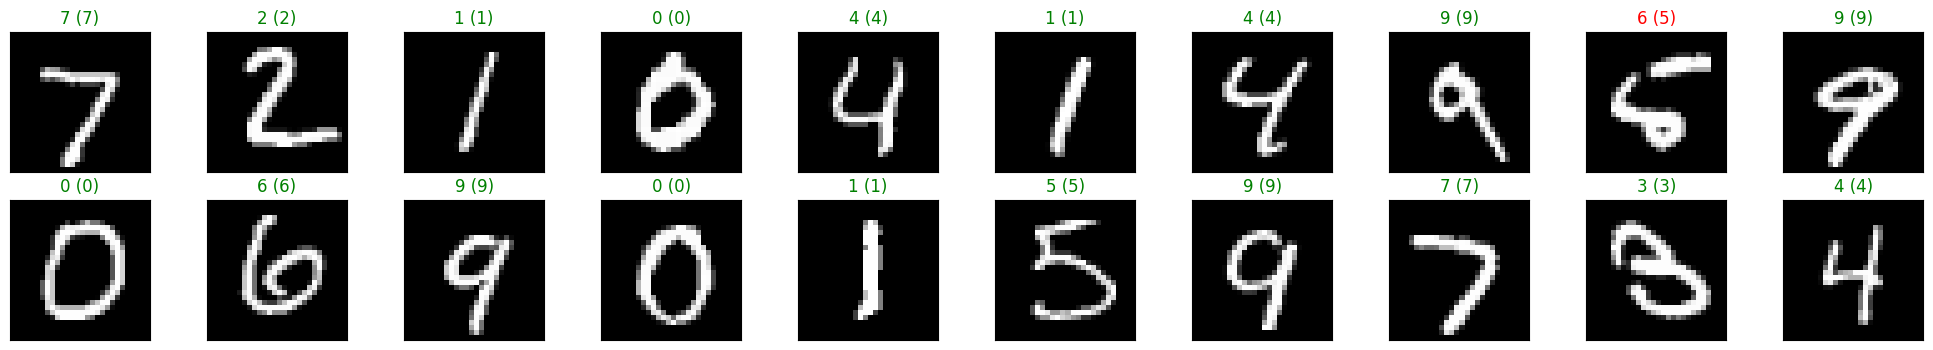

In [ ]:
visualization(model_1, test_loader)

### 10- Incorrect predictions

First of all, let us extract predicted (*preds*) and ground truth (*targets*) labels for images arising from the test set.

In [ ]:
def get_all_prediction(model, loader):
    preds = torch.tensor([], dtype=torch.long)
    targets = torch.tensor([], dtype=torch.long)
    for data, label in loader:
        data = data.to(device=device, dtype=torch.float32)
        label = label.to(device=device, dtype=torch.long)
        with torch.no_grad():
            output = model(data)
        targets = torch.cat((targets, label.cpu()), dim = 0)
        preds = torch.cat((preds, torch.max(output.cpu(), 1)[1]), dim = 0)
    return targets.numpy(), preds.numpy()

In [ ]:
targets, preds_1 = get_all_prediction(model_1, test_loader)

We are now ready to visualize some of the incorrect predictions.

<ipython-input-22-e603a31b923f>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.title("{} ({})".format(str(np.int(preds_1[index[i]])), str(np.int(targets[index[i]]))),color=("red"))


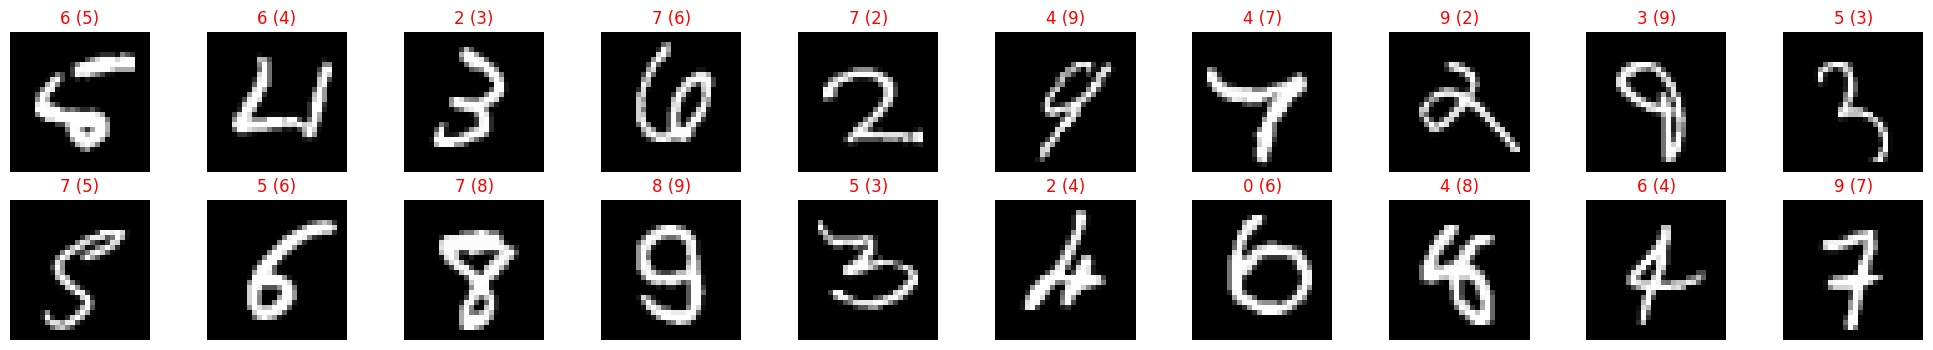

In [ ]:
index = np.where(preds_1 - targets != 0)[0]
test_set_array = test_data.data.numpy()
plt.figure(figsize=(25, 4))
for i in range(20):
  plt.subplot(2, 10, i + 1)
  plt.axis('off')
  plt.imshow(test_set_array[index[i],:,:], cmap='gray')
  plt.title("{} ({})".format(str(np.int(preds_1[index[i]])), str(np.int(targets[index[i]]))),color=("red"))
plt.show()

### 11- Confusion matrix

The confusion matrix is a specific table layout that allows visualization of the performance of an algorithm. Each row of the matrix corresponds to the instances in a ground truth class while each column represents the instances in an predicted class (or vice versa).

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

class_names= ['0','1','2','3','4','5','6','7','8','9']

def plot_confusion_matrix(cm, classes, normalize=False, title='confusion matrix', cmap=plt.cm.Blues):
    # This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("normalized confusion matrix")
    else:
        print('confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('true label')
    plt.xlabel('predicted label')

normalized confusion matrix


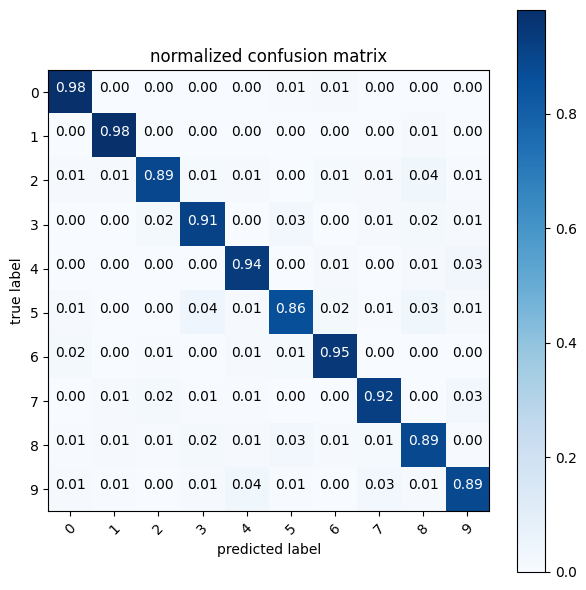

In [ ]:
# compute confusion matrix
cnf_matrix = confusion_matrix(targets, preds_1)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='normalized confusion matrix')

plt.show()

#### **Question 11.1** - What are the most common errors? **Answer**: ...
The most common errors are thinking things are an 8 when they are not. In particular the 2, 2% of cases.
9 is also detected incorrectly in 4% of cases of 4 and 3% of 7.
5 is also detected incorrectly in 3% of cases of 3 and 3% of 8.
7 is also detected incorrectly in 3% of cases of 7.
there is a particular confusion between 7 and 9

### 12- Deeper MLP

Our goal is to define a new architecture and train the network to reach (at least) 97% of global accuracy for the test dataset.

#### **Question 12.1** - Define a deeper network architecture. In practice, we may use two hidden layers (with 512 neurons) as well as dropout ([documentation](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)) to avoid overfitting.

In [ ]:
#Que es dropout y donde lo meto

class Net2(nn.Module):
    def __init__(self):
        super(Net2,self).__init__()

        self.relu= nn.ReLU() #hago la activacion
        self.dropout =nn.Dropout(p=0.2) #Dropout, para que no se base en una caracteristica en particular, y se fije todo en general. Se aplica a la salida de cada hidden layer

        self.fc1 = nn.Linear(28*28, 512) #primer hidden layer
        self.fc2 = nn.Linear(512, 512)   #segunda hidden layer
        self.fc3 = nn.Linear(512, 10)    #output

    def forward(self,x):
        x = x.view(-1,28*28) # flatten input image
        print(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
model_2 = Net2()
model_2.to(device=device)

Net2(
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)

#### **Question 12.2** - Train the new MLP model (*Net2*).

#### Define an optimizer for model_2.

In [ ]:
optimizer = torch.optim.SGD(model_2.parameters(),lr = 0.01) # specify optimizer (stochastic gradient descent) and learning rate

#### Use the "training" function in Section 6 to train the model_2.

In [ ]:
train_losses_2, valid_losses_2 = training(n_epochs, train_loader, valid_loader, model_2, criterion, optimizer)

epoch: 1 	training Loss: 0.936954 	validation Loss: 0.364986
validation loss decreased (inf --> 0.364986).  Saving model ...
epoch: 2 	training Loss: 0.356349 	validation Loss: 0.275310
validation loss decreased (0.364986 --> 0.275310).  Saving model ...
epoch: 3 	training Loss: 0.282886 	validation Loss: 0.236176
validation loss decreased (0.275310 --> 0.236176).  Saving model ...
epoch: 4 	training Loss: 0.235486 	validation Loss: 0.197885
validation loss decreased (0.236176 --> 0.197885).  Saving model ...
epoch: 5 	training Loss: 0.199386 	validation Loss: 0.169877
validation loss decreased (0.197885 --> 0.169877).  Saving model ...
epoch: 6 	training Loss: 0.173360 	validation Loss: 0.149017
validation loss decreased (0.169877 --> 0.149017).  Saving model ...
epoch: 7 	training Loss: 0.153737 	validation Loss: 0.134508
validation loss decreased (0.149017 --> 0.134508).  Saving model ...
epoch: 8 	training Loss: 0.137893 	validation Loss: 0.123335
validation loss decreased (0.13450

#### **Question 12.3** - For comparison purposes, display in a single graph the loss functions for both training and validation sets and both models (*Net1* and *Net2*).

Text(0, 0.5, 'loss value')

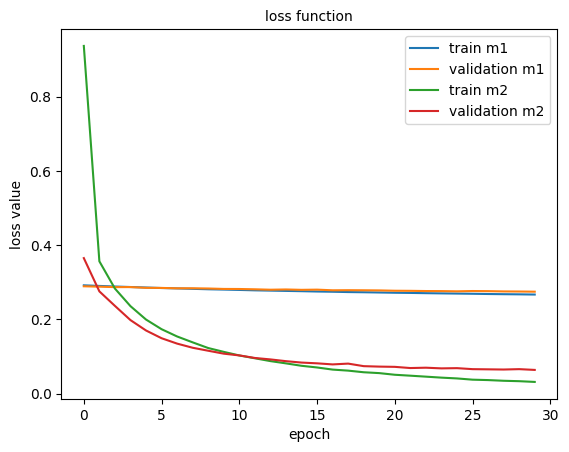

In [ ]:
#Epoch, cada vez que actualizo los pesos

plt.plot(range(n_epochs), train_losses_1)
plt.plot(range(n_epochs), valid_losses_1)

plt.plot(range(n_epochs), train_losses_2)
plt.plot(range(n_epochs), valid_losses_2)

plt.legend(['train m1', 'validation m1', 'train m2', 'validation m2'], prop={'size': 10})
plt.title('loss function', size=10)
plt.xlabel('epoch', size=10)
plt.ylabel('loss value', size=10)


#Vemos que la m2 da mucho mejor

#### **Question 12.4** - Perform the quantitative assessment by computing per-class and overall accuracy scores.

In [ ]:
model_2.load_state_dict(torch.load('model.pt', map_location=device))

<All keys matched successfully>

#### Use the Evaluation function defined in Section 8 to assess the performance of model_2

In [ ]:
evaluation(model_2, test_loader, criterion)

test Loss: 0.059249

test accuracy of 0: 98% (969/980)
test accuracy of 1: 98% (1123/1135)
test accuracy of 2: 97% (1010/1032)
test accuracy of 3: 98% (991/1010)
test accuracy of 4: 97% (961/982)
test accuracy of 5: 97% (873/892)
test accuracy of 6: 97% (938/958)
test accuracy of 7: 97% (1006/1028)
test accuracy of 8: 96% (938/974)
test accuracy of 9: 97% (983/1009)

test accuracy (overall): 97.92% (9792/10000)


#### **Question 12.5** - Perform the qualitative assessment by displaying some test images with their predicted and ground truth labels.

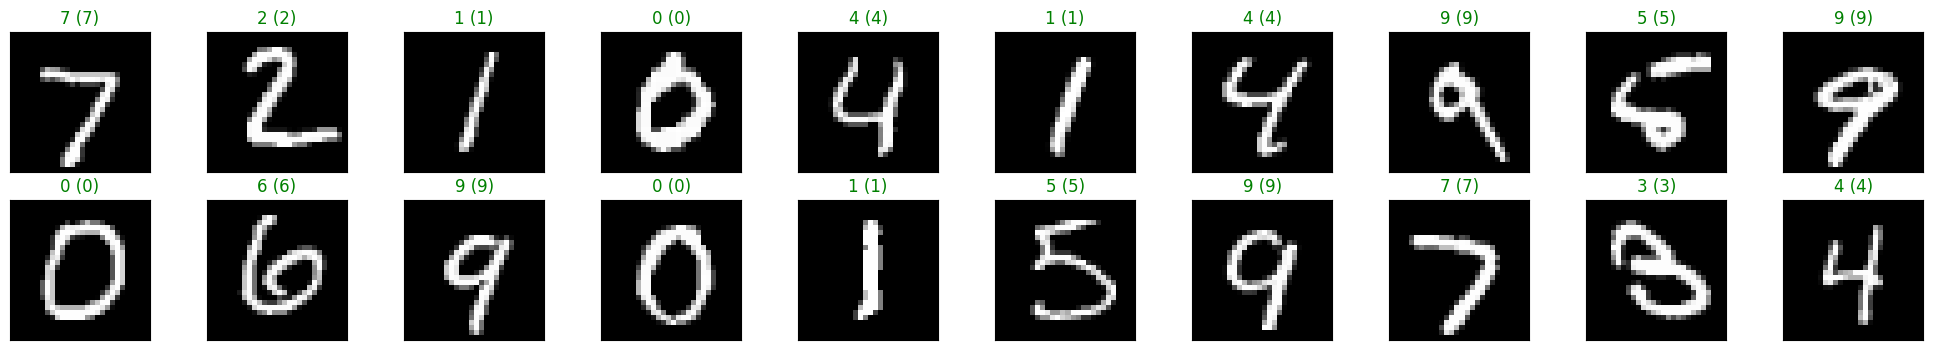

In [ ]:
visualization(model_2, test_loader)

#### **Question 12.6** - Compute the predicted labels for the test set and display the resulting confusion matrix.

In [ ]:
targets, preds_2 = get_all_prediction(model_2, test_loader)

normalized confusion matrix


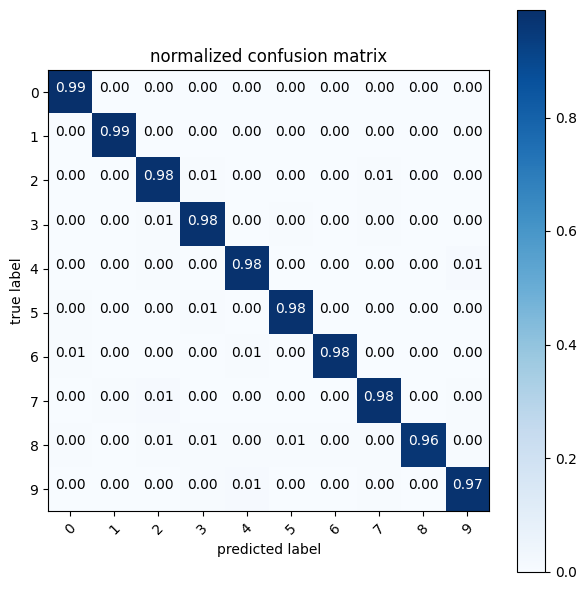

In [ ]:
# compute confusion matrix
cnf_matrix = confusion_matrix(targets, preds_2)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='normalized confusion matrix')

plt.show()



---

